In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4304 sha256=84dfc9cb963065bc813c7ee3f7ccf86aca28a903494625d7be4c6fe3229ad481
  Stored in directory: /root/.cache/pip/wheels/6d/2d/d6/158260bfd6820d144535857b80cc112bee5c3aa6d81b6dc049
Successfully built py_vncorenlp


In [ ]:
import py_vncorenlp
import os

# Define the save directory
save_dir = '/content/vncorenlp'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Download the model
py_vncorenlp.download_model(save_dir=save_dir)

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=save_dir)

In [ ]:
text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

output = rdrsegmenter.word_segment(text)


In [ ]:
import re
def remove_emoji(text):
    # Sử dụng biểu thức chính quy để loại bỏ emoji
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Mặt cười
        "\U0001F300-\U0001F5FF"  # Ký hiệu & biểu tượng
        "\U0001F680-\U0001F6FF"  # Giao thông & biển báo
        "\U0001F700-\U0001F77F"  # Các biểu tượng khác
        "\U0001F780-\U0001F7FF"  # Các biểu tượng bổ sung
        "\U0001F800-\U0001F8FF"  # Các ký hiệu bổ sung
        "\U0001F900-\U0001F9FF"  # Biểu tượng bổ sung (ví dụ: tay, khuôn mặt)
        "\U0001FA00-\U0001FA6F"  # Biểu tượng bổ sung mới
        "\U0001FA70-\U0001FAFF"  # Biểu tượng bổ sung mới
        "\U00002702-\U000027B0"  # Ký hiệu bổ sung
        "\U000024C2-\U0001F251"  # Ký tự đặc biệt
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(" ", text)

def preprocess_text(text):
    # Chuẩn hóa Unicode (NFC)

    # Loại bỏ emoji
    text = remove_emoji(text)

    # Loại bỏ các ký tự không phải chữ cái, số và khoảng trắng (bao gồm cả tiếng Việt)
    text = re.sub(r"[^a-zA-Z0-9À-ỹà-ỹ\s]", " ", text)

    # Chuyển văn bản về chữ thường
    text = text.lower()

    # Loại bỏ khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()
    text = rdrsegmenter.word_segment(text)
    return "".join(text)

In [ ]:
output

['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .',
 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

In [ ]:
import pandas as pd

df_dev = pd.read_parquet("/content/dev-00000-of-00001.parquet")
df_test = pd.read_parquet("/content/test-00000-of-00001.parquet")
df_train = pd.read_parquet("/content/train-00000-of-00001.parquet")


In [ ]:
df_train['Statement'] = df_train['Statement'].apply(preprocess_text)
df_train['Evidence'] = df_train['Evidence'].apply(preprocess_text)
df_dev['Statement'] = df_dev['Statement'].apply(preprocess_text)
df_dev['Evidence'] = df_dev['Evidence'].apply(preprocess_text)
df_test['Statement'] = df_test['Statement'].apply(preprocess_text)
df_test['Evidence'] = df_test['Evidence'].apply(preprocess_text)

In [ ]:
len(df_dev), len(df_test), len(df_train)

(723, 1447, 5062)

In [ ]:
df_dev.head(3)

,Unnamed: 0,index,Statement,Context,annotation_id,Topic,Author,Url,labels,Evidence
0,0,6040,vào tháng 4 1930 tl nhà_vua na_uy harald v vua...,"Saigon Morin, khách sạn 4 sao hàng đầu tại Huế...",18220511,Du lịch,Thanh Niên,https://thanhnien.vn/khach-san-lau-doi-nhat-co...,1,vua hề charlie chaplin vua hề_sác lô và vợ từn...
1,1,5599,nhiều chi_bộ chỉ mua báo đảng mà không quan_tâ...,"(Chinhphu.vn) - Bí thư Trung ương Đảng, Trưởng...",18537674,Chính trị,Chính Phủ,https://baochinhphu.vn/phat-huy-gia-tri-bao-ta...,1,việc mua đọc sử_dụng báo tạp_chí của đảng tại ...
2,2,1947,công_ty tnhh mua_bán nợ dsp địa_chỉ 91 pasteur...,(NLĐO)- Sau khi mua khoản nợ từ Công ty Mirae ...,19570487,Pháp luật,Người lao động,https://nld.com.vn/phap-luat/cong-ty-o-tp-hcm-...,1,công_ty tnhh mua_bán nợ dsp địa_chỉ tầng 4 chu...


In [ ]:
import warnings
import logging
import torch
import pandas as pd
import ast
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report
import transformers

In [ ]:
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, labels, tokenizer, max_length):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        sentence1, sentence2 = self.sentence_pairs[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            sentence1,
            text_pair=sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
            return_overflowing_tokens=False
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }


In [ ]:
class PhoBERTClassifier(nn.Module):
    def __init__(self, phobert, num_classes):
        super(PhoBERTClassifier, self).__init__()
        self.phobert = phobert
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.phobert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.phobert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False,
        )
        dropout_output = self.dropout(pooled_output)
        logits = self.linear(dropout_output)
        return logits

In [ ]:
def prepare_dataset(data):
    statements = list(data["Statement"])
    evidences = list(data["Evidence"])

    return [(s, e) for s, e in zip(statements, evidences)]

In [ ]:
X_train = prepare_dataset(df_train)
X_test = prepare_dataset(df_test)
X_dev = prepare_dataset(df_dev)

In [ ]:
y_train = list(df_train["labels"])
y_test = list(df_test["labels"])
y_dev = list(df_dev["labels"])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-large")
phobert = AutoModel.from_pretrained("vinai/phobert-large")
max_length = 256

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [ ]:
train_dataset = SentencePairDataset(X_train, y_train, tokenizer, max_length)
dev_dataset = SentencePairDataset(X_dev, y_dev, tokenizer, max_length)
test_dataset = SentencePairDataset(X_test, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16,num_workers=8,shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16,num_workers=8,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16,num_workers=8,shuffle=False)


model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PhoBERTClassifier(phobert, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,
)


In [ ]:
import torch
import torch.nn as nn
import torch.amp
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
def train_model_text_classification(model, train_loader, val_loader, criterion, optimizer,
                                    num_epochs=10, device='cuda', early_stop_patience=3,
                                    model_save_path='/content/drive/MyDrive/vi_fact_check/model_text_cls.pth', metric_to_monitor='acc'):

    best_val_metric = -float('inf')
    early_stop_counter = 0
    best_epoch = 0

    model.to(device)
    # Lưu lịch sử để vẽ đồ thị
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds, all_labels = [], []

        train_pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)
        for batch in train_pbar:
            model.train()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="[Validation]", leave=False)
            for batch in val_pbar:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)


        print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
        print(f"--- Train ---     Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | F1: {train_f1:.4f}")
        print(f"--- Validation --- Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}% | F1: {val_f1:.4f}")

        current_val_metric = val_f1 if metric_to_monitor == 'f1' else val_acc

        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_epoch = epoch
            early_stop_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"✅ Model improved & saved to {model_save_path}")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch+1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = train_model_text_classification(
    model,
    train_loader,
    dev_loader,
    criterion,
    optimizer,
    num_epochs=15,
    early_stop_patience=7,
    metric_to_monitor='acc'
)


[Epoch 1/15] Training:  74%|███████▍  | 235/317 [03:51<01:21,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 1/15
--- Train ---     Loss: 1.0942 | Acc: 36.49% | F1: 0.3357
--- Validation --- Loss: 1.0534 | Acc: 46.75% | F1: 0.4253
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 2/15] Training:  43%|████▎     | 136/317 [02:14<03:00,  1.00it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 2/15
--- Train ---     Loss: 0.7791 | Acc: 65.80% | F1: 0.6532
--- Validation --- Loss: 0.5680 | Acc: 76.63% | F1: 0.7705
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 3/15] Training:   3%|▎         | 8/317 [00:08<05:06,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 3/15
--- Train ---     Loss: 0.4075 | Acc: 85.22% | F1: 0.8517
--- Validation --- Loss: 0.6283 | Acc: 80.08% | F1: 0.8006
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 4/15] Training:  67%|██████▋   | 211/317 [03:28<01:44,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 4/15
--- Train ---     Loss: 0.2539 | Acc: 91.66% | F1: 0.9164
--- Validation --- Loss: 0.4376 | Acc: 83.68% | F1: 0.8387
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 5/15] Training:  75%|███████▍  | 237/317 [03:54<01:19,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 5/15
--- Train ---     Loss: 0.1397 | Acc: 95.67% | F1: 0.9567
--- Validation --- Loss: 0.4877 | Acc: 83.96% | F1: 0.8396
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 6/15] Training:  94%|█████████▎| 297/317 [04:53<00:19,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 6/15
--- Train ---     Loss: 0.0958 | Acc: 97.14% | F1: 0.9713
--- Validation --- Loss: 0.6743 | Acc: 84.09% | F1: 0.8411
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 7/15] Training:  79%|███████▉  | 250/317 [04:07<01:06,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 7/15
--- Train ---     Loss: 0.0690 | Acc: 97.91% | F1: 0.9790
--- Validation --- Loss: 0.6217 | Acc: 82.99% | F1: 0.8307
⏳ Early Stop Counter: 1/7


[Epoch 8/15] Training:  30%|███       | 96/317 [01:35<03:38,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 8/15
--- Train ---     Loss: 0.0440 | Acc: 98.62% | F1: 0.9862
--- Validation --- Loss: 0.6154 | Acc: 86.45% | F1: 0.8644
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 9/15] Training:  87%|████████▋ | 277/317 [04:34<00:39,  1.02it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 9/15
--- Train ---     Loss: 0.0487 | Acc: 98.66% | F1: 0.9866
--- Validation --- Loss: 0.6697 | Acc: 84.92% | F1: 0.8492
⏳ Early Stop Counter: 1/7


[Epoch 10/15] Training:  70%|███████   | 222/317 [03:39<01:33,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 10/15
--- Train ---     Loss: 0.0249 | Acc: 99.33% | F1: 0.9933
--- Validation --- Loss: 0.6898 | Acc: 84.92% | F1: 0.8504
⏳ Early Stop Counter: 2/7


[Epoch 11/15] Training:  74%|███████▍  | 235/317 [03:52<01:21,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 11/15
--- Train ---     Loss: 0.0248 | Acc: 99.35% | F1: 0.9935
--- Validation --- Loss: 0.6035 | Acc: 85.62% | F1: 0.8569
⏳ Early Stop Counter: 3/7


[Epoch 12/15] Training:  22%|██▏       | 69/317 [01:08<04:05,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 12/15
--- Train ---     Loss: 0.0341 | Acc: 99.07% | F1: 0.9907
--- Validation --- Loss: 0.7633 | Acc: 86.03% | F1: 0.8605
⏳ Early Stop Counter: 4/7


[Epoch 13/15] Training:  57%|█████▋    | 182/317 [03:00<02:13,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 13/15
--- Train ---     Loss: 0.0270 | Acc: 99.13% | F1: 0.9913
--- Validation --- Loss: 0.7431 | Acc: 85.75% | F1: 0.8576
⏳ Early Stop Counter: 5/7


[Epoch 14/15] Training:   2%|▏         | 5/317 [00:05<05:19,  1.02s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



📊 Epoch 14/15
--- Train ---     Loss: 0.0334 | Acc: 99.07% | F1: 0.9907
--- Validation --- Loss: 0.6667 | Acc: 86.58% | F1: 0.8663
✅ Model improved & saved to /content/drive/MyDrive/vi_fact_check/model_text_cls.pth


[Epoch 15/15] Training:  83%|████████▎ | 262/317 [04:19<00:54,  1.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
                                                             


📊 Epoch 15/15
--- Train ---     Loss: 0.0223 | Acc: 99.35% | F1: 0.9935
--- Validation --- Loss: 0.7212 | Acc: 86.03% | F1: 0.8599
⏳ Early Stop Counter: 1/7


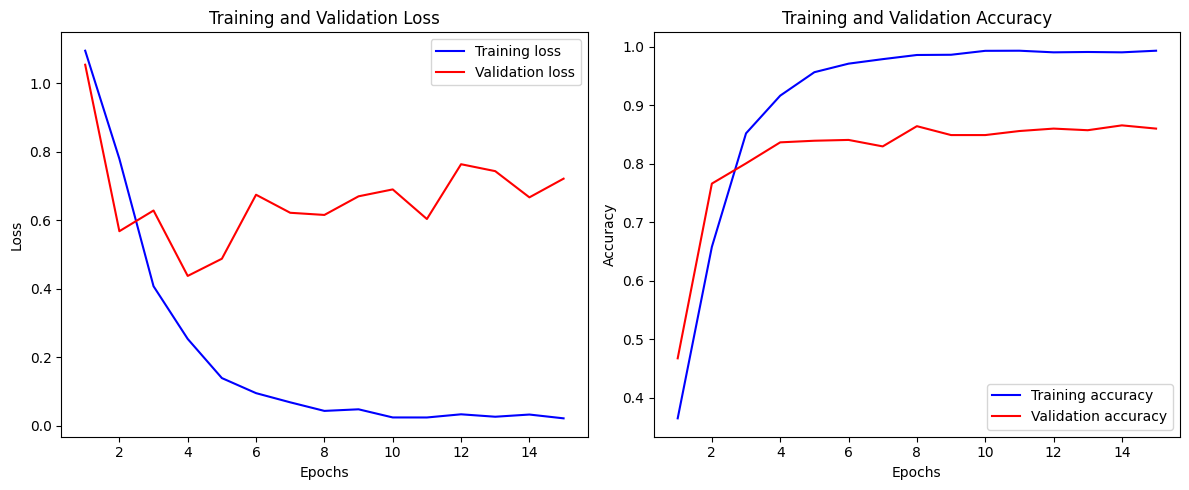

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
def test_model_text_classification(model, test_loader, model_path,
                                   device='cuda', return_preds=False):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, classification_report

    # Load model đã huấn luyện
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="[Testing]", leave=False)
        for batch in test_pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print("\n📊 Test Results:")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"F1-score: {f1:.4f}")
    print("\nDetailed Report:\n", classification_report(all_labels, all_preds, zero_division=0))

    if return_preds:
        return all_labels, all_preds
    else:
        return acc, f1


In [ ]:
test_model_text_classification(model, test_loader, model_path="/content/drive/MyDrive/vi_fact_check/model_text_cls.pth")

[Testing]:  67%|██████▋   | 61/91 [00:20<00:09,  3.09it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
                                                          


📊 Test Results:
Accuracy: 85.07%
F1-score: 0.8506

Detailed Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       508
           1       0.82      0.84      0.83       468
           2       0.90      0.83      0.86       471

    accuracy                           0.85      1447
   macro avg       0.85      0.85      0.85      1447
weighted avg       0.85      0.85      0.85      1447



(0.8507256392536282, 0.8506028018015034)